# Fine-Tuning Stable Diffusion

This notebook is a supplementary material for the Fine-Tuning Stable Diffusion of the [Hands-On Generative AI with Transformers and Diffusion Models book](https://learning.oreilly.com/library/view/hands-on-generative-ai/9781098149239/). This notebook includes:

* The code from the book
* Additional examples
* Exercise solutions

## Full Stable Diffusion Fine-Tuning

### Preparing the Dataset


In [ ]:
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir="/path/to/folder")

In [ ]:
dataset.push_to_hub("my-hf-username/my-incredible-dataset")

### Fine-Tuning the Model


In [ ]:
git clone https://github.com/huggingface/diffusers.git 
cd diffusers/examples/text_to_image/

In [ ]:
accelerate launch train_text_to_image.py \
--pretrained_model_name_or_path="stable-diffusion-v1-5/stable-diffusion-v1-5" \
--dataset_name="Supermaxman/esa-hubble" \
--use_ema \
--mixed_precision="fp16" \
--resolution=512 \
--center_crop \
--random_flip \
--train_batch_size=1 \
--gradient_checkpointing \
--gradient_accumulation_steps=4 \
--use_8bit_adam \
--checkpointing_steps=1000 \
--num_train_epochs=50 \
--validation_prompts \
    "Hubble image of a colorful ringed nebula: \
A new vibrant ring-shaped nebula was imaged by the \
NASA/ESA Hubble Space Telescope." \
    "Pink-tinted plumes in the Large Magellanic Cloud: \
The aggressively pink plumes seen in this image are extremely uncommon, \
with purple-tinted currents and nebulous strands reaching out into \
the surrounding space." \
--validation_epochs 5 \
--learning_rate=1e-05 \
--output_dir="sd-hubble-model" \
--push_to_hub

### Inference

In [ ]:
import torch
from diffusers import StableDiffusionPipeline

from genaibook.core import get_device

model_id = "Supermaxman/hubble-diffusion-1"
device = get_device()
pipe = StableDiffusionPipeline.from_pretrained(
    model_id,  # your-hf-username/your-finetuned-model
    torch_dtype=torch.float16,
).to(device)

  0%|          | 0/50 [00:00<?, ?it/s]

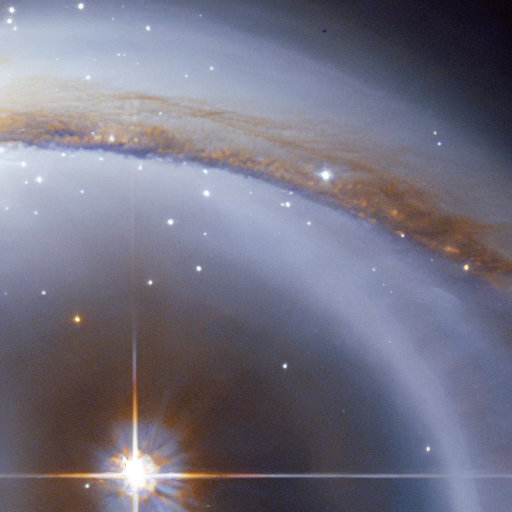

In [6]:
prompt = (
    "Hubble reveals a cosmic dance of binary stars: In this stunning new image "
    "from the Hubble Space Telescope, a pair of binary stars orbit each other in a "
    "mesmerizing ballet of gravity and light. The interaction between these two "
    "stellar partners causes them to shine brighter, offering astronomers crucial "
    "insights into the mechanics of dual-star systems."
)

pipe(prompt).images[0]

## Dreambooth

### Dreamboothing the Model


In [ ]:
accelerate launch train_dreambooth.py \
--pretrained_model_name_or_path="stable-diffusion-v1-5/stable-diffusion-v1-5"  \
--instance_data_dir="my-pictures" \
--instance_prompt="a photo of plstps" \  # <1>
--resolution=512 \
--train_batch_size=1 \
--with_prior_preservation \
--class_prompt="an ultra realistic portrait of a man" \  # <2>
--gradient_accumulation_steps=1 \
--train_text_encoder \
--learning_rate=5e-6 \
--num_train_epochs=100 \
--output_dir="myself-model" \
--push_to_hub

### Inference

In [ ]:
model_id = "your-hf-profile/your-custom-dreambooth-model"
pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
).to(device)

prompt = "a photo of plstps speaking on a microphone"  # Insert here your instance prompt and some custom customization
pipe(prompt).images[0]

## Training LoRAs

In [2]:
from diffusers import DiffusionPipeline
from huggingface_hub.repocard import RepoCard

# We'll use a classic hand drawn cartoon style
lora_model_id = "alvdansen/littletinies"

# Determine which is the base model
# This information is frequently in the model card
# It's CompVis/stable-diffusion-v1-4 in this case
card = RepoCard.load(lora_model_id)
base_model_id = card.data["base_model"]

# Load the base model
pipe = DiffusionPipeline.from_pretrained(
    base_model_id, torch_dtype=torch.float16
)
pipe = pipe.to(device)

# Add the LoRA to the model
pipe.load_lora_weights(lora_model_id)

# Merge the LoRA with the base model
pipe.fuse_lora()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
image = pipe(
    "A llama drinking boba tea", num_inference_steps=25, guidance_scale=7.5
).images[0]
image

## Solutions

A big part of learning is putting your knowledge into practice. We strongly suggest not looking at the answers before taking a serious stab at it. Scroll down for the answers.

### Exercises

**1. Explain the main differences between full model fine-tuning and DreamBooth.**

Full fine-tuning:

* Requires significant amount of data.
* Data augmentation is often necessary to prevent overfitting
* Can lead to catastrophic forgetting.

DreamBooth:

* Often creates outputs involving a specific concept, subject or style
* Works with few examples
* Retains general knowledge, resulting in a more versatile model.

**2. What are the advantages of using LoRA over full model fine-tuning regarding computational resources and model adaptability?**

* As only a small part of the model is fine-tuned, LoRA requires fewer computational resources.
* Saving LoRA models can only require storing the low-rank parameters, reducing storage requirements.
* As only few parameters are fine-tuned, LoRA models are trained faster.
* Different low-rank adaptations can be stored separately and composed or swapped in and out as needed.

**3. Why is it important to utilize a unique token when doing DreamBooth training?**

Unique tokens prevent the new concept from interfering with existing knowledge in the model. This way, the model can learn to generate outputs that are consistent with the new concept while retaining its general knowledge.

**4. Besides teaching new concepts, fine-tuning can also add new capabilities to the model. Cite two capabilities that the model can learn by applying fine-tuning techniques.**

Inpainting
* The model learns to fill in missing parts of an image with contextually relevant content.
* How: fine-tuning the model with masked images and their original counterparts.

Depth-aware image generation
* The model learns to generate images with understanding of 3D depth, allowing for more realistic and accurate outputs.
* How: fine-tuning the model with depth maps and their corresponding images.


**5. Discuss how the choice of hyperparameters affects the outcome of fine-tuning a diffusion model.**

The choice of hyperparameters significantly influences the outcome of fine-tuning a diffusion model, impacting both the quality of generated images and the model's ability to learn new concepts. The learning rate is particularly crucial; too high, and the model may overfit or fail to converge, while too low could result in underfitting or excessively long training times. The number of training epochs affects the balance between underfitting and overfitting – too few, and the model may not fully learn the new concept, while too many could lead to overfitting and loss of generalization ability. Batch size impacts training stability and memory usage, with larger batches potentially providing more stable gradients but requiring more computational resources. 

For diffusion models specifically, parameters like the noise schedule can affect the balance between preserving existing knowledge and acquiring new capabilities. The choice of optimizer, such as AdamW or 8-bit Adam, can influence training efficiency and the model's ability to generalize. Ultimately, careful tuning of these hyperparameters is essential to achieve a fine-tuned model that effectively learns new concepts or styles while maintaining its overall performance and generalization capabilities.


**6. Describe the potential risks of fine-tuning text-to-image models on biased datasets.**

1. The model may perpetuate or amplify societal biases present in the training data.
2. The dataset may be skewed towards certain classes or concepts, leading to imbalanced learning and biased outputs.
3. Fine-tuning on violent, discriminatory, or harmful content can result in the model generating inappropriate or harmful images.
4. Biased outputs from the model may be used as training data for other models or tools, creating a self-reinforcing cycle where biases are amplified over time.

### Challenges

**7. LoRA Versus Full-Fine Tuning Comparison. Train a DreamBooth model with LoRA and full-fine tuning and compare the results. Try to modify the “rank” hyperparameter for the LoRA to see how much it affects the results.**